In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["figure.figsize"] = (12, 4)
plt.rcParams["font.size"] = 14
plt.style.use('fivethirtyeight')

# Bias adjustment when predicting `log Y` instead of `Y`

## 1. Regular linear regression

In a linear regression task, we predict `E[Y|X=x]`. The assuption here is that for every value of `X=x`, the response $Y$ is normally distributed with mean $w^T x$ and some unknown variance $\sigma^2$.

$$Y \sim N(wx, \sigma^2)$$

$E[Y|X=x] = \int_{-\infty}^\infty y f(y|X=x)dy$. Since we assumed that $Y$ is normally distributed this is the same as $E[Y|X=x] = \frac{1}{\sqrt{2\pi}\sigma }\int_{-\infty}^\infty y \exp\left(\frac{-(y-\mu)^2}{2\sigma^2}\right)dy = \mu = wx$. We've substitued the form of the normal distribution.

> Imagine for every value of $X=x$, there's a normal distribution with a different mean representing the probability density function $P(Y|X=x)$. We are taking the expectation of the normal function $P(Y|X=x)$. For a normal distribution the expected value is the mean which we defined as $\mu=wx$.

<img src="./linreg-normal-dist.jpeg" width="50%"/>

## 2. Linear regression when the output is log normal

Above for every value of $X=x$ we assumed that the output was normally distributed with a mean of $\mu=wx$. What if you know that conditioned on $X=x$, the log of the response is normally distributed? $$\log Y \sim N(wx, \sigma^2)$$

We can build a linear regression model $\left[\log Y = wx + \epsilon\right]$. Similar to above $E[\log Y|X=x] = wx$ but we want to know $E[Y|X=x]$.

### 2.1 Why can't we simply exponentiate?
The predictions will be biased and we will be consistently **underestimating** the response.

$$ E[Y|X=x] \geq \exp\left(E[\log Y|X=x]\right) $$

(( here the expectations are taken over $y \sim P(Y=y|X=x)$ ))

#### Explanation 1 with Jensen's inequality
If you're familiar with Jensen's inequality for convex/concave functions ([yt video](https://www.youtube.com/watch?v=LOwj7UxQwJ0) explaining this), we know that $E[\log (Y|X=x)] \leq \log(E[Y|X=x])$ . Also since $\exp$ is a monotonic function,
$$ \exp\left(E[\log Y|X=x]\right) \leq E[Y|X=x]$$

#### Explanation 2
$$
\begin{align*}
\log Y &= wx + \epsilon \quad \left(\epsilon \sim N(0, \sigma^2)\right)\\
Y &= e^{wx}e^\epsilon \\
E[Y|X=x] &= E[e^{wx}]E[e^\epsilon] \\
&= e^{\widehat{\log y}} e^{\left(\frac{\sigma^2}{2}\right)}\\
\text{where the below is }&\text{the prediction of linear regression} \\
\widehat{\log y} & = wx
\end{align*}
$$
<br/>
Since, $\exp$ of any positive number is greater than 1, after the correction the prediction value increases (because our original estimate is underestimate).
<br/>
<br/>

$$
\begin{align*}
\text{ypred_bias_corrected} &= e^{\widehat{\log y}} E[e^\epsilon] \\
&= e^{wx} E[e^\epsilon] \\
E[e^\epsilon] = e^{\left(\frac{\sigma^2}{2}\right)} &\approx \frac{1}{n} \sum_{i=1}^n e^{r_i} \quad \text{where $r_i$ are the residues (logy_true-logy_pred)} \\
\text{ypred_bias_corrected} = \widehat{E[Y|X=x]} &= e^{\widehat{\log y}} \left(\frac{1}{n} \sum_{i=1}^n e^{r_i} \right)
\end{align*}
$$

### 2.2 Simulation
#### Create dataset

$\log Y \sim N(\mu=0.2 x + 0.1,\quad \sigma^2=0.09)$

In [2]:
n = 100_000
sigma = 0.3

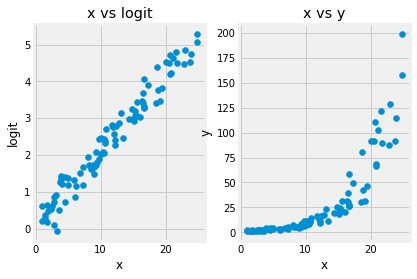

In [3]:
x = np.random.random(n)*25
logit = 0.2*x + 0.1 + np.random.normal(loc=0., scale=sigma, size=n)
y = np.exp(logit);
plt.subplot(121)
ixes = np.random.random(n) < 0.001
plt.scatter(x[ixes], logit[ixes])
plt.xlabel('x'); plt.ylabel('logit'); plt.title('x vs logit');
plt.subplot(122)
plt.scatter(x[ixes], y[ixes])
plt.xlabel('x'); plt.ylabel('y'); plt.title('x vs y');
plt.show()

#### Fitting a linear regrssion line

We then assume our linear regression gives us the exact weight and bias, 0.2 and 0.1 respectively. We then estimate `logy_pred = log y = 0.2 * x + 0.1`.

The uncorrected prediction `ypred = exp(logy_pred) = exp(0.2*x + 0.1)`\
The corrected prediction `ypred_bias_cor = exp(logy_pred)*exp(sigma^2/2) = exp(0.2*x + 0.1)*exp(sigma^2/2)`

Finally, since we don't observe `sigma`, we will estimate $E[e^\epsilon] \approx \left(\frac{1}{n} \sum_{i=1}^n e^{r_i} \right)$ with ` np.exp(logy_pred-logy).mean()`.

In [4]:
# no correction
logy_pred = 0.2*x + 0.1
ypred = np.exp(logy_pred)

# adjustment if we had access to the unknown variance sigma^2
correction_true =  np.exp(sigma**2/2)
ypred_bias_cor = ypred * correction_true

# adjustment if we have to estimate sigma^2
correction_est = np.exp( (logit-logy_pred)).mean()
ypred_bias_cor_est = ypred *correction_est

print(f"True correction exp(σ^2/2) \t\t\t{correction_true}")
print(f"Correstion estimate exp(logy_pred-logy).mean() \t{correction_est}\n\n")
print(f"Bias for uncorrected prediction \t\t\t\t{(y-ypred).mean()}")
print(f"Bias for corrected prediction with true correction \t\t{(y-ypred_bias_cor).mean()}")
print(f"Bias for corrected prediction with correction estimate \t\t{(y-ypred_bias_cor_est).mean()}")

True correction exp(σ^2/2) 			1.046027859908717
Correstion estimate exp(logy_pred-logy).mean() 	1.046596736133511


Bias for uncorrected prediction 				1.484678291204287
Bias for corrected prediction with true correction 		-0.02431155648719088
Bias for corrected prediction with correction estimate 		-0.04296174899037445
